In [ ]:
dados_f1 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F1.csv'
dados_f2 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F2.csv'
dados_f3 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F3.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Fazenda 1

![Alt text: Imagem de uma fazenda com plantações de uvas](https://github.com/Mirlaa/s-ries-temporais-statsmodels/blob/main/imagens/Fazenda%201.png?raw=true)

In [ ]:
df_f1 = pd.read_csv(dados_f1)
df_f1

,DATA,TEMP
0,1963-05-01,23.11
1,1963-06-01,24.20
2,1963-07-01,25.37
3,1963-08-01,23.86
4,1963-09-01,23.03
...,...,...
727,2023-12-01,19.49
728,2024-01-01,19.28
729,2024-02-01,19.73
730,2024-03-01,20.44


In [ ]:
df_f1['DATA'] = pd.to_datetime(df_f1['DATA'], format='%Y-%m-%d')
df_f1.set_index(['DATA'], inplace=True, drop=True)
df_f1

,TEMP
DATA,
1963-05-01,23.11
1963-06-01,24.20
1963-07-01,25.37
1963-08-01,23.86
1963-09-01,23.03
...,...
2023-12-01,19.49
2024-01-01,19.28
2024-02-01,19.73


<Axes: xlabel='DATA'>

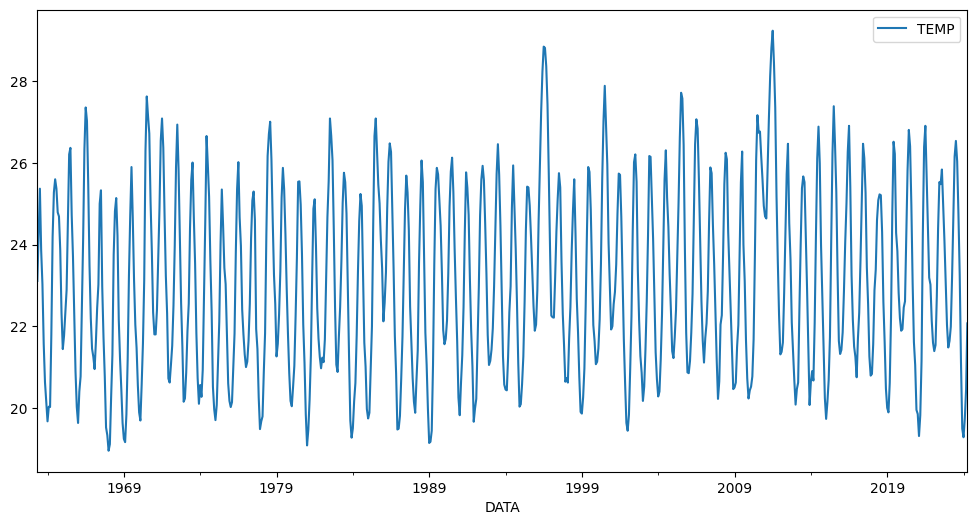

In [ ]:
df_f1.plot(figsize=(12,6))

## Modelo ingênuo

Um modelo ingênuo (naive) em séries temporais é um dos métodos de previsão mais simples, baseando-se na suposição de que o melhor preditor para qualquer ponto futuro é o valor mais recente disponível na série. Isso significa que a previsão para todos os pontos futuros será igual ao último valor observado.

In [ ]:
df_f1.shift(1)

,TEMP
DATA,
1963-05-01,NaN
1963-06-01,23.11
1963-07-01,24.20
1963-08-01,25.37
1963-09-01,23.86
...,...
2023-12-01,21.11
2024-01-01,19.49
2024-02-01,19.28


## Avaliando a estacionariedade

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def estac(df):

  adf = adfuller(df)
  print(f'Valor-p do Teste ADF: {adf[1]:.4f}')
  if adf[1] > 0.05:
    print('Não rejeitar a Hipótese Nula: a série não é estacionária\n')
  else:
    print('Rejeitar a Hipótese Nula: a série é estacionária\n')

  kpss_saida = kpss(df)
  print(f'Valor-p do Teste KPSS: {kpss_saida[1]:.4f}')
  if kpss_saida[1] > 0.05:
    print('Não rejeitar a Hipótese Nula: a série é estacionária\n')
  else:
    print('Rejeitar a Hipótese Nula: a série não é estacionária\n')

In [ ]:
estac(df_f1)

Valor-p do Teste ADF: 0.0000
Rejeitar a Hipótese Nula: a série é estacionária

Valor-p do Teste KPSS: 0.0798
Não rejeitar a Hipótese Nula: a série é estacionária



In [ ]:
divisao = int(len(df_f1)*0.70)

treino = df_f1.iloc[:divisao].asfreq('MS')
teste = df_f1.iloc[divisao:].asfreq("MS")

## Modelo Autoregressivo (AR)

Um modelo Autorregressivo (AR) é um tipo de modelo de previsão para séries temporais que utiliza uma combinação linear de valores passados da própria série para fazer previsões futuras. Ele se baseia na ideia de que observações passadas podem ser usadas para prever observações futuras de maneira estatisticamente significativa, especialmente quando a série exibe correlação ao longo do tempo.

A equação básica de um modelo autorregressivo de ordem $(p)$ (lag de $p$ períodos) é dada por:

$X_t = c + \beta_1 X_{t-1} + \beta_2 X_{t-2} + \dots + \beta_p X_{t-p} + \epsilon_t$

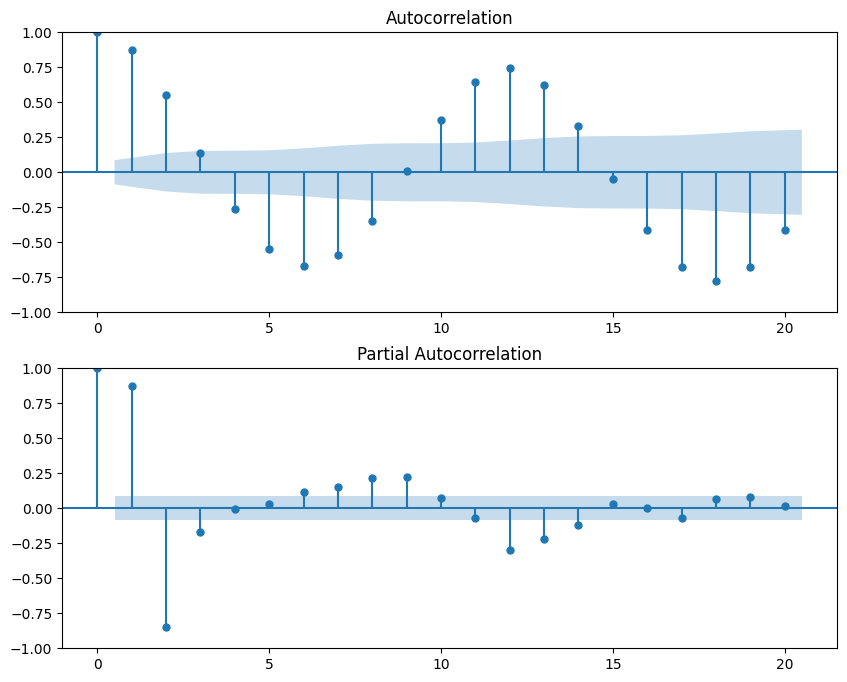

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=20, ax=ax2)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

ar_mod = AutoReg(treino,14, old_names=False)
ar_res = ar_mod.fit()
print(ar_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(14)   Log Likelihood                -317.490
Method:               Conditional MLE   S.D. of innovations              0.458
Date:                Wed, 26 Jun 2024   AIC                            666.981
Time:                        14:22:19   BIC                            734.350
Sample:                    07-01-1964   HQIC                           693.421
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0973      0.649      7.855      0.000       3.825       6.369
TEMP.L1        1.1971      0.044     27.078      0.000       1.110       1.284
TEMP.L2       -0.3092      0.069     -4.470      0.0

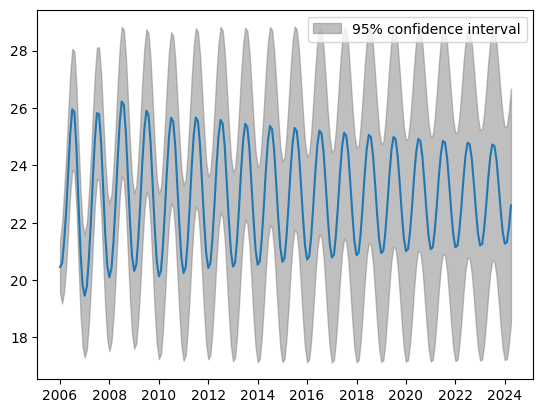

In [ ]:
from statsmodels.tsa.ar_model import AutoRegResults

mod_result = AutoRegResults(ar_mod, ar_res.params, ar_res.cov_params())

fig = mod_result.plot_predict(len(treino), len(treino)+len(teste)-1)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_prev(treino, teste, mod, nome_mod = ''):

  previsoes = mod.predict(len(treino), len(treino) + len(teste)-1, dynamic=False)

  plt.figure(figsize=(12, 5))

  plt.plot(teste.index, teste, label='Esperado')
  plt.plot(previsoes.index, previsoes, label='Previsto', color='red')

  plt.title(f'Previsão modelo {nome_mod}')
  plt.ylabel('Temperatura')
  plt.legend()
  plt.show()

  print('\nMétricas:\n')
  mae = mean_absolute_error(teste, previsoes)
  print(f'MAE: {mae}')

  mse = mean_squared_error(teste, previsoes)
  print(f'MSE: {mse}')

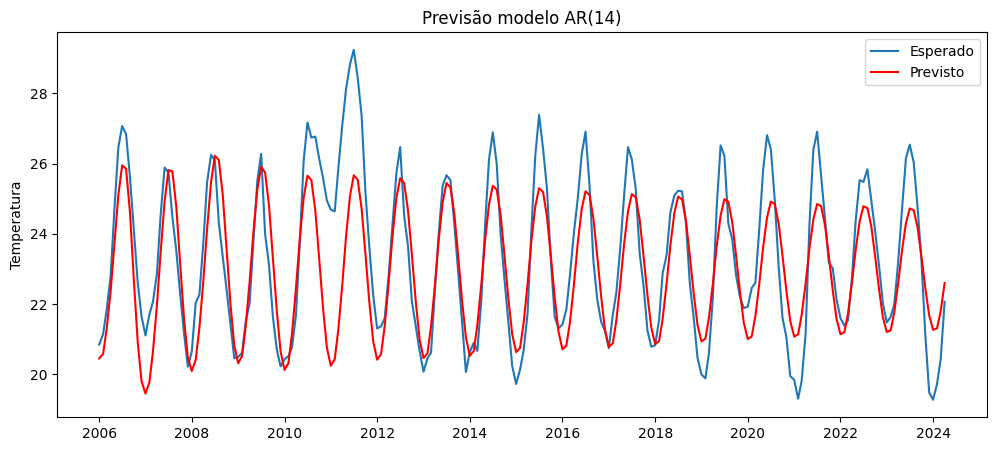


Métricas:

MAE: 1.042706398397448
MSE: 1.8489038142175698


In [ ]:
plot_prev(treino,teste, ar_res, 'AR(14)')

### Busca de parâmetros

In [ ]:
from statsmodels.tsa.ar_model import ar_select_order

ar_selecao = ar_select_order(treino,35,old_names=False, ic='aic')

In [ ]:
ar_selecao.ar_lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

In [ ]:
ar_sel_res = ar_selecao.model.fit()
print(ar_sel_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(34)   Log Likelihood                -265.842
Method:               Conditional MLE   S.D. of innovations              0.422
Date:                Wed, 26 Jun 2024   AIC                            603.684
Time:                        14:22:23   BIC                            753.790
Sample:                    03-01-1966   HQIC                           662.698
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4648      1.091      4.092      0.000       2.326       6.603
TEMP.L1        1.1355      0.045     25.067      0.000       1.047       1.224
TEMP.L2       -0.2017      0.068     -2.958      0.0

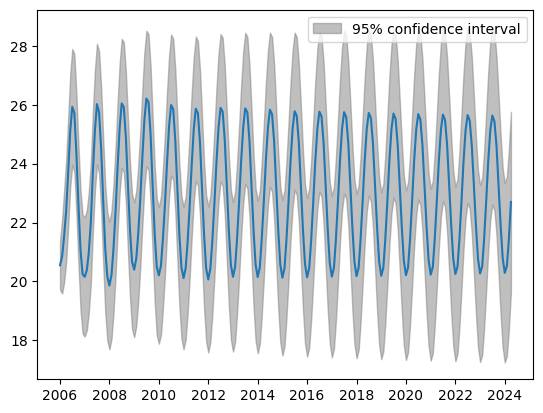

In [ ]:
fig = ar_sel_res.plot_predict(len(treino), len(treino) + len(teste)-1)

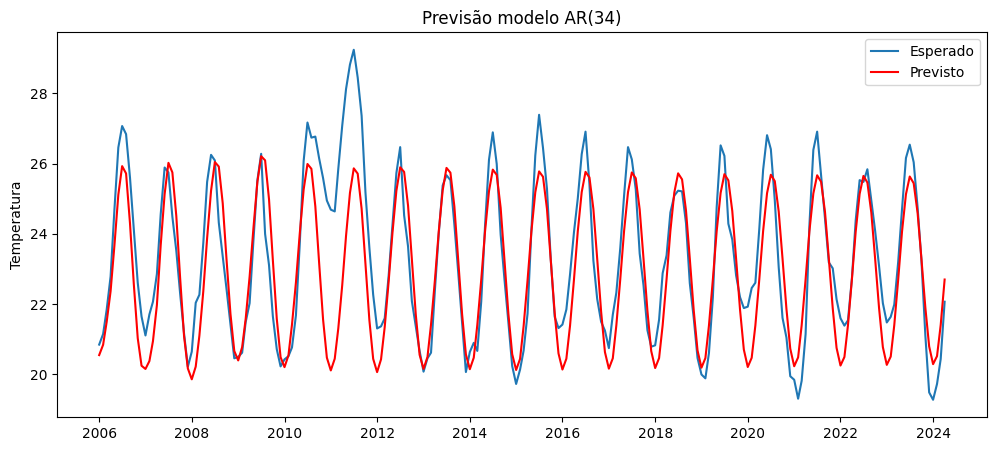


Métricas:

MAE: 0.9474776896251889
MSE: 1.661067311337596


In [ ]:
plot_prev(treino,teste,ar_sel_res,'AR(34)')

# Fazenda 2

![Alt text: Imagem de uma fazenda com plantações de tomates](https://github.com/Mirlaa/s-ries-temporais-statsmodels/blob/main/imagens/Fazenda%202.png?raw=true)

In [ ]:
df_f2['DATA'] = pd.to_datetime(df_f2['DATA'], format='%Y-%m-%d')
df_f2.set_index(['DATA'], inplace=True, drop=True)
fig = df_f2.plot(figsize=(12, 6))

In [ ]:


treino = df_f2.iloc[:divisao].asfreq('MS')
teste = df_f2.iloc[divisao:].asfreq('MS')

## Construindo um modelo previsivo

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=11, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=11, ax=ax2)

### Modelo Autorregressivo de Médias Móveis (ARMA)

O modelo ARMA é uma ferramenta estatística avançada usada na análise de séries temporais que combina duas características principais: autoregressiva (AR) e média móvel (MA).

O modelo ARMA é expresso pela seguinte equação:

$X_t = c + \epsilon_t + \sum_{i=1}^p \beta_i X_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j}$

In [ ]:
arma_mod.plot_diagnostics(figsize=(15, 12))
plt.show()

### Busca de parâmetros

In [ ]:
import itertools


def grid_arima(p_inicial, p_final, q_inicial, q_final, d_valores, treino):
  # Definindo os parâmetros
  p_params = range(p_inicial, p_final)
  q_params = range(q_inicial, q_final)
  d_params = [d_valores]

  # Gerando todas as combinações possíveis usando product
  combinacoes = list(itertools.product(p_params, d_params, q_params))

  aic_grid = dict()
  # Treinando o modelo e salvando todas combinações
  for order in combinacoes:
    try:
      model = ARIMA(treino, order = order).fit()
      aic_grid[order] = list()
      aic_grid[order].append((model.aic if model.aic else float('inf')))
    except:
      continue
  return aic_grid, min(aic_grid, key=lambda x: aic_grid[x][0])

# Fazenda 3

![Alt text: Imagem de uma fazenda com plantações de arroz](https://github.com/Mirlaa/s-ries-temporais-statsmodels/blob/main/imagens/Fazenda%203.png?raw=true)

In [ ]:
df_f3['DATA'] = pd.to_datetime(df_f3['DATA'], format='%Y-%m-%d')
df_f3.set_index(['DATA'], inplace=True, drop=True)
fig = df_f3.plot(figsize=(12, 6))

## Modelo Integrado Autorregressivo de Média Móveis (ARIMA)

In [ ]:
divisao = int(len(df_f3) * 0.8)

treino = df_f3.iloc[:divisao].asfreq('MS')
teste = df_f3.iloc[divisao:].asfreq('MS')

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=20, ax=ax2)

O modelo ARIMA combina três componentes principais: autorregressivo (AR), diferenciado (I de Integrated, ou integrado) e de média móvel (MA), o que o torna capaz de modelar uma ampla variedade de dados temporais.

O modelo ARIMA é geralmente representado como ARIMA(p, d, q), onde:

- $(p)$ é o número de termos autoregressivos,
- $( d )$ é o número de diferenciações necessárias para tornar a série temporal estacionária,
- $( q )$ é o número de termos de média móvel.

A equação genérica do modelo ARIMA é:

$(1 - \sum_{i=1}^p \beta_i L^i)(1 - L)^d X_t = (1 + \sum_{j=1}^q \theta_j L^j) \epsilon_t$

### Busca de parâmetros

In [ ]:
aic_arima = grid_arima(14,25,1,3,1,treino)

In [ ]:
aic_arima[1]

(24, 1, 2)

In [ ]:
arima_mod_ot = ARIMA(treino, order = (24, 1, 2)).fit()
print(arima_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  563
Model:                ARIMA(24, 1, 2)   Log Likelihood                -504.938
Date:                Wed, 26 Jun 2024   AIC                           1063.876
Time:                        14:33:45   BIC                           1180.827
Sample:                    09-01-1965   HQIC                          1109.535
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4442      0.152     -2.928      0.003      -0.742      -0.147
ar.L2          0.1559      0.086      1.811      0.070      -0.013       0.325
ar.L3         -0.1382      0.072     -1.931      0.0

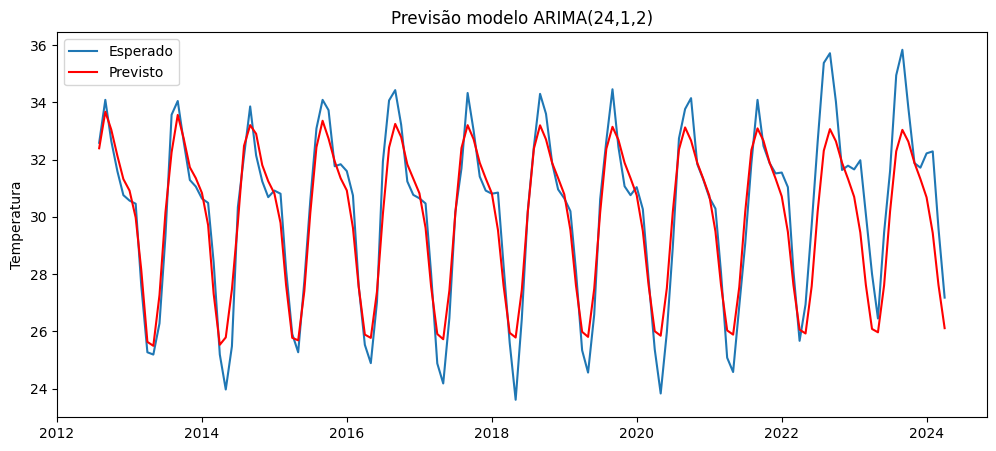


Métricas:

MAE: 0.8308415470649783
MSE: 1.1579346525653609


In [ ]:
plot_prev(treino, teste, arima_mod_ot, 'ARIMA(24,1,2)')

### **A sazonalidade**

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=48, ax=ax2)

## Modelo Autorregressivo Sazonal de Média Móveis Integrado (SARIMA)

O modelo SARIMA é uma extensão do modelo ARIMA, projetado especificamente para modelar e prever séries temporais que exibem sazonalidade.

O modelo SARIMA pode ser descrito pela seguinte equação, que combina tanto os efeitos sazonais quanto os não sazonais:

$(1 - \sum_{i=1}^p \beta_i L^i)(1 - \sum_{i=1}^P B_i L^{is})(1 - L)^d(1 - L^s)^D X_t = (1 + \sum_{j=1}^q \theta_j L^j)(1 + \sum_{j=1}^Q \Theta_j L^{js}) \epsilon_t$

# Previsões das Fazendas

Temos 3 modelos para 3 conjuntos de dados sobre as temperaturas das fazendas

* Fazenda 1 modelo $AR(34)$
* Fazenda 2 modelo $ARMA(24,2)$
* Fazenda 3 modelo $SARIMA(11, 1, 1)\times (2, 1, 1, 12)$

```Python
mod_f1 = AutoReg(df_f1, 34, old_names=False).fit()
mod_f2 = ARIMA(df_f2, order=(24,0,2)).fit()
mod_f3 = SARIMAX(df_f3, order=(11, 1, 1), seasonal_order=(2, 1, 1, 12)).fit()
```